# Exploratory Data Analysis

* [1. Integer-type features](#1)
* [2. Float-type features](#2)
* [3. Datetime-type features](#3)
* [4. String-type features](#4)       
* [5. Summary](#5)

The vast majority of the features in our anonymized dataset are numerical columns (1837 integers and 10 floats) with a tiny admixture of categorical ones (17 strings and 16 datetime types). In principle, numerical features can easily be fed into machine learning models with no need for understaning their meanings. The only challenge we're facing is a complicated structure of missing values, encoded by NaNs or numerous integers (-99999, -1, 99, 999, 9999, 9999999999), which we will try to understand in this section. We will also investigate selected categorical features and propose an optimal way to replace them with numerical ones.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

#common for all
y = pd.read_csv("./data/work_target.csv",index_col='ID',low_memory=False)
y.shape

(145231, 1)

### 1. Integer-type features<a id='1'></a>

In [2]:
dfi = pd.read_csv("./data/work_integers.csv",index_col='ID',low_memory=False).convert_dtypes()
dpi = pd.read_csv("./data/pred_integers.csv",index_col='ID',low_memory=False).convert_dtypes()

dfi.shape, dpi.shape

((145231, 1837), (145232, 1837))

Let's start with missing values encoded with -1 and -99999. They populate high number of rows in columns depicted with dark and light blue color on the plot in Sec. 4.1 of the [previous notebook](./data_wrangling.ipynb#4.1). Let's select columns with -1. Let's remove -1 from the dataset and check what are the next smallest numbers:

In [3]:
dfi_min = dfi.min()

cols_a = dfi_min[dfi_min == -1].index
print(len(cols_a))

dfi_a = dfi[cols_a][dfi[cols_a] != -1]
set(dfi_a.min())

104


{0.0, 1.0, 3.0, 15.0, 1995.0}

The smallest is a zero. OK. Let's do the same for columns with -99999. Let's select them, then let's remove -99999 from the dataset then check what are the next smallest numbers::

In [4]:
cols_b = dfi_min[dfi_min == -99999].index
print('N columns = ',len(cols_b))

dfi_b = dfi[cols_b][dfi[cols_b] != -99999]
set(dfi_b.min())

N columns =  156


{0.0, 1.0, 6.0, 9.0, 18.0, 20.0, 56.0, 374.0, 456.0, 5000.0}

Cool. The smallest is a zero again. The same situation as for -1. So we will replace -99999 with -1. Done.

Let's now move to large positive numbers: 99, 999, 9999 and 9999999999. Let's select 99 and check the next largest number, then do the same for others.

In [5]:
dfi_max = dfi.max()

cols_c = dfi_max[dfi_max == 99].index
print('N columns = ',len(cols_c))

dfi_c = dfi[cols_c][dfi[cols_c] != 99]
print(set(dfi_c.max()))

N columns =  458
{1.0, 2.0, 3.0, 4.0, 7.0, 9.0, 10.0, 11.0, 12.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 24.0, 26.0, 28.0, 29.0, 32.0, 34.0, 35.0, 37.0, 43.0, 44.0, 45.0, 47.0, 49.0, 55.0, 57.0, 60.0, 64.0, 66.0, 67.0, 69.0, 70.0, 73.0, 74.0, 84.0, 86.0, 90.0, 93.0, 94.0, 96.0, 97.0, 98.0}


In [6]:
cols_c = dfi_max[dfi_max == 999].index
print('N columns = ',len(cols_c))

dfi_c = dfi[cols_c][dfi[cols_c] != 999]
set(dfi_c.max())

N columns =  238


{100.0, 400.0, 975.0, 984.0, 994.0, 995.0, 997.0, 998.0}

In [7]:
cols_c = dfi_max[dfi_max == 9999].index
print('N columns = ', len(cols_c))

dfi_c = dfi[cols_c][dfi[cols_c] != 9999]
set(dfi_c.max())

N columns =  159


{24.0, 222.0, 9994.0, 9996.0, 9998.0}

In [8]:
cols_c = dfi_max[dfi_max == 999999999].index
print('N columns = ', len(cols_c))

dfi_c = dfi[cols_c][dfi[cols_c] != 999999999]
set(dfi_c.max())

N columns =  257


{966493.0,
 2392017.0,
 3229192.0,
 131786791.0,
 999999996.0,
 999999997.0,
 999999998.0}

Ha! The 99 requires some more printing as it seems, the corresponding columns contain numbers from the range 0-99. Perhaps is not a missing number...

The other 3 cases have a bizarre structure, in which in addition to regular distributions the sets of numbers [999,998,997] or [9999,9998,9997,9996] or [999999999-999999996] are present. This will require more studies.

__MORE TO COME__

### 2. Float-type features<a id='2'></a>

In [9]:
dff = pd.read_csv("./data/work_floats.csv",index_col='ID',low_memory=False).convert_dtypes()
dpf = pd.read_csv("./data/pred_floats.csv",index_col='ID',low_memory=False).convert_dtypes()

dff.shape, dpf.shape

((145231, 10), (145232, 10))

Our float variables contain 3 types of differently encoded missing values. Since there are only 10 such variables, let's plot them all, and also print their missing values. When plotting, let's temporarily replace -1  with -10, to better visually separate them from the non-zero spectra in the data:

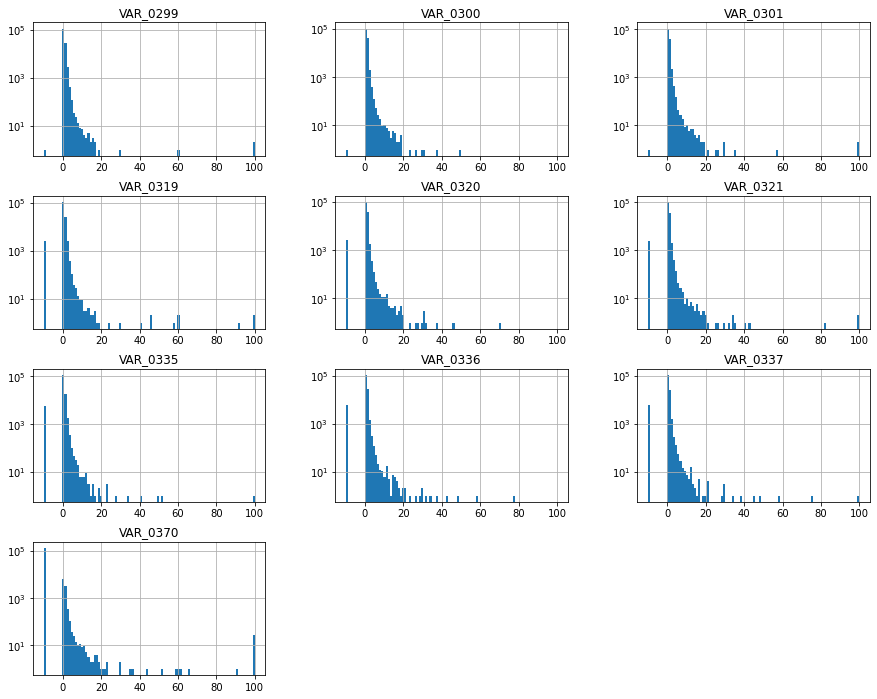

In [10]:
dff.replace(-1,-10).hist(figsize=(15,12),bins=101,range=(-10,100),log=True);

In [11]:
fmiss = dff.agg([lambda x: x.isna().sum(),lambda x: (x == -1).sum(),lambda x: (x == 99).sum()],axis=0)
fmiss.index = ['n( NaN)','n( -1)', 'n( 99)']
fmiss.T

,n( NaN),n( -1),n( 99)
VAR_0299,918,1,2
VAR_0300,918,1,0
VAR_0301,918,1,2
VAR_0319,918,2521,2
VAR_0320,918,2521,0
VAR_0321,918,2521,2
VAR_0335,918,5944,1
VAR_0336,918,5944,0
VAR_0337,918,5944,1
VAR_0370,918,134450,28


In all the columns NaNs are missing in 918 rows, they correspond to the lack of data in the same way as -1 do, so we will replace all the instances of NaN by -1. As for the number 99, it is significantly present only in the last column, it might represent a saturation threshold above which no values are allowed, so we will leave it unchanged. 

In [12]:
dff = dff.fillna(-1)
dpf = dpf.fillna(-1)

In [13]:
dff.isna().sum()

VAR_0299    0
VAR_0300    0
VAR_0301    0
VAR_0319    0
VAR_0320    0
VAR_0321    0
VAR_0335    0
VAR_0336    0
VAR_0337    0
VAR_0370    0
dtype: int64

What about correlations? Are the columns correlated?:

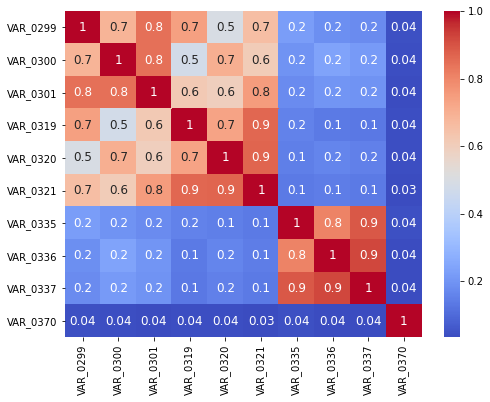

In [14]:
cm = dff.corr()

f, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(cm,cmap='coolwarm',annot=True,fmt='.1g',annot_kws={"size":12});

Yes, they are, in particular within each of the 3 groups of columns with adjacent ID: 299-301, 319-321, 335-33. They also happen to have the same number of missing numbers encoded as -1. But is this a useful information? We could probably manually remove 2 out 3 variables for each of the adjacent groups, e.g. by setting the threshold on Pearson's correlation coefficient to be smaller than 0.7. This would reduce the total number of float columns from 10 to 4, but... is 0.7 a good threshold to preserve all the information in the current data? Let's leave all the columns in, hoping that generic dimensionality reduction algorithms, which we will apply later, will make a more justified decision for us.

### 3. Datetime-type features<a id='3'></a>

Let's load the data parsing the approperiate datetime format, which we saw in Sec. 4.3 of the [previous notebook](./data_wrangling.ipynb#4.3):

In [15]:
dft = pd.read_csv("./data/work_datetimes.csv",index_col='ID',low_memory=False)
dpt = pd.read_csv("./data/pred_datetimes.csv",index_col='ID',low_memory=False)

for col in dft.columns:
    dft[col] = pd.to_datetime(dft[col],format='%d%b%y:%H:%M:%S')
    dpt[col] = pd.to_datetime(dpt[col],format='%d%b%y:%H:%M:%S')
    
dft.shape,dpt.shape

((145231, 16), (145232, 16))

In [16]:
dft.dtypes

VAR_0073    datetime64[ns]
VAR_0075    datetime64[ns]
VAR_0156    datetime64[ns]
VAR_0157    datetime64[ns]
VAR_0158    datetime64[ns]
VAR_0159    datetime64[ns]
VAR_0166    datetime64[ns]
VAR_0167    datetime64[ns]
VAR_0168    datetime64[ns]
VAR_0169    datetime64[ns]
VAR_0176    datetime64[ns]
VAR_0177    datetime64[ns]
VAR_0178    datetime64[ns]
VAR_0179    datetime64[ns]
VAR_0204    datetime64[ns]
VAR_0217    datetime64[ns]
dtype: object

The format is recognized correctly. Let's print a few rows:

In [17]:
dft.dropna().head()

,VAR_0073,VAR_0075,VAR_0156,VAR_0157,VAR_0158,VAR_0159,VAR_0166,VAR_0167,VAR_0168,VAR_0169,VAR_0176,VAR_0177,VAR_0178,VAR_0179,VAR_0204,VAR_0217
ID,,,,,,,,,,,,,,,,
249,2012-10-01,2009-11-02,2011-05-05,2011-06-05,2012-03-01,2012-02-02,2010-04-05,2012-05-21,2011-04-20,2012-04-13,2010-04-05,2012-05-21,2012-03-01,2012-04-13,2014-02-01 00:16:00,2012-10-03 02:00:00
17628,2012-02-26,2011-09-02,2011-09-02,2012-03-08,2011-12-12,2012-01-25,2011-09-02,2012-03-08,2011-12-15,2012-02-13,2011-09-02,2012-03-08,2011-12-15,2012-02-13,2014-01-30 22:44:00,2012-05-11 02:00:00
23801,2012-08-07,2010-07-20,2010-12-01,2011-04-29,2011-02-04,2011-02-07,2010-12-01,2011-05-14,2011-04-15,2011-04-15,2010-12-01,2011-05-14,2011-04-15,2011-04-15,2014-02-01 01:02:00,2012-10-23 02:00:00
31786,2012-02-28,2010-12-14,2011-10-10,2012-02-11,2012-01-06,2012-01-26,2011-06-06,2012-02-07,2011-12-23,2011-12-08,2011-06-06,2012-02-11,2012-01-06,2012-01-26,2014-01-30 22:53:00,2012-05-17 02:00:00
65173,2012-10-27,2009-03-07,2011-11-21,2012-10-10,2012-07-27,2012-07-31,2012-04-10,2012-10-19,2012-06-15,2012-10-01,2011-11-21,2012-10-19,2012-07-27,2012-10-01,2014-02-01 01:24:00,2012-10-30 02:00:00


and recall the fraction of missing values per column:

In [18]:
(dft.isna().sum()*100/dft.shape[0]).round(2).astype('str') + ' %'

VAR_0073    69.63 %
VAR_0075     0.04 %
VAR_0156    95.96 %
VAR_0157    99.37 %
VAR_0158    98.56 %
VAR_0159    95.96 %
VAR_0166     90.2 %
VAR_0167    98.23 %
VAR_0168    92.62 %
VAR_0169     90.2 %
VAR_0176    87.93 %
VAR_0177    97.69 %
VAR_0178    91.69 %
VAR_0179    87.93 %
VAR_0204     0.04 %
VAR_0217     0.04 %
dtype: object

Let's also print the min and max date for each column, and the difference between them (in hours and in years):

In [19]:
diff_d = lambda x: round((x.max() - x.min())/np.timedelta64(1, 'D'))
diff_y = lambda x: round((x.max() - x.min())/np.timedelta64(1, 'Y'))

t_range = dft.apply(['min','max',diff_d, diff_y])
t_range.index = ['T min','T max', 'dT( days)','dT( years)']
t_range.T

,T min,T max,dT( days),dT( years)
VAR_0073,2008-01-02 00:00:00,2012-10-31 00:00:00,1764,5
VAR_0075,2001-01-01 00:00:00,2012-11-01 00:00:00,4322,12
VAR_0156,2008-04-11 00:00:00,2012-10-29 00:00:00,1662,5
VAR_0157,2008-10-17 00:00:00,2012-10-31 00:00:00,1475,4
VAR_0158,2008-09-30 00:00:00,2012-10-29 00:00:00,1490,4
VAR_0159,2008-09-23 00:00:00,2012-10-29 00:00:00,1497,4
VAR_0166,2002-07-30 00:00:00,2012-10-30 00:00:00,3745,10
VAR_0167,2005-02-12 00:00:00,2012-10-30 00:00:00,2817,8
VAR_0168,1999-12-31 00:00:00,2012-11-01 00:00:00,4689,13
VAR_0169,2002-07-30 00:00:00,2012-11-01 00:00:00,3747,10


Interesting. Column 204 spans the time inverval of 2 days, from Jan 29 to Feb 1 in the year 2014, column 217 covers a period of one year in 2012, all the other columns span multiple years (from 4 to 13), with the latest date in 2012. 

What's inside column 204? Let's plot the hour of the day versus the day of the month for the data in this column: 

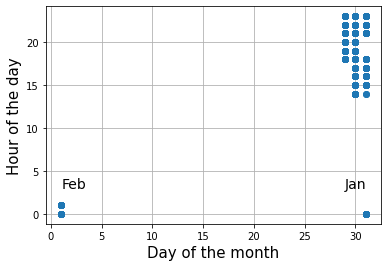

In [20]:
plt.plot(dft['VAR_0204'].dt.day, dft['VAR_0204'].dt.hour,'o')
plt.grid()
plt.xlabel('Day of the month',fontsize=15)
plt.ylabel('Hour of the day',fontsize=15)
plt.text(29, 3, 'Jan',fontsize=14)
plt.text( 1, 3, 'Feb',fontsize=14);

The data covers hours from about 2 PM and about 2 AM, regardless of the day (notice the jump from Jan to Feb). This might be somebody's 12-hour working day or a shift in a hospital. 

How is column 204 related to other columns? To anwer this question we will convert the data format from absolute dates to a time difference w.r.t. the starting date of column 204:

In [21]:
dft_diff = dft - dft['VAR_0204'].min()
dft_diff.head()

,VAR_0073,VAR_0075,VAR_0156,VAR_0157,VAR_0158,VAR_0159,VAR_0166,VAR_0167,VAR_0168,VAR_0169,VAR_0176,VAR_0177,VAR_0178,VAR_0179,VAR_0204,VAR_0217
ID,,,,,,,,,,,,,,,,
2,NaT,-814 days +05:15:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 02:31:00,-814 days +07:15:00
4,-513 days +05:15:00,-812 days +05:15:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2 days 05:26:00,-485 days +07:15:00
5,NaT,-779 days +05:15:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 20:26:00,-779 days +07:15:00
7,NaT,-1225 days +05:15:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2 days 05:22:00,-455 days +07:15:00
8,NaT,-838 days +05:15:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:46:00,-838 days +07:15:00


Let's check now the relation between column 204 and column 217 (the one with the second shortest time span):

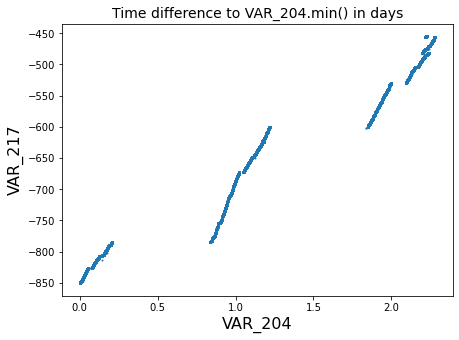

In [22]:
tunit = np.timedelta64(1,'D')

plt.figure(figsize=(7,5))
plt.scatter(dft_diff['VAR_0204']/tunit,dft_diff['VAR_0217']/tunit,s=1)

plt.title('Time difference to VAR_204.min() in days',fontsize=14)
plt.xlabel('VAR_204',fontsize=16)
plt.ylabel('VAR_217',fontsize=16);

Almost 1:1 correspondence! It's possible that during 3 days in 2014 (VAR_204) somebody was analizing chronologically-ordered data recorded over the period of ~400 days in the year 2012 (VAR_217). In any case, the VAR_204 variable seems redundant and could be removed from the dataset.

Now let's recall that the maximum date for remaining columns corresponds to the year 2012 as well. Is there any relation between these columns and column VAR_217? Let's inspect it by plotting the time difference bewteen each of the remaining columns and VAR_217:

/data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


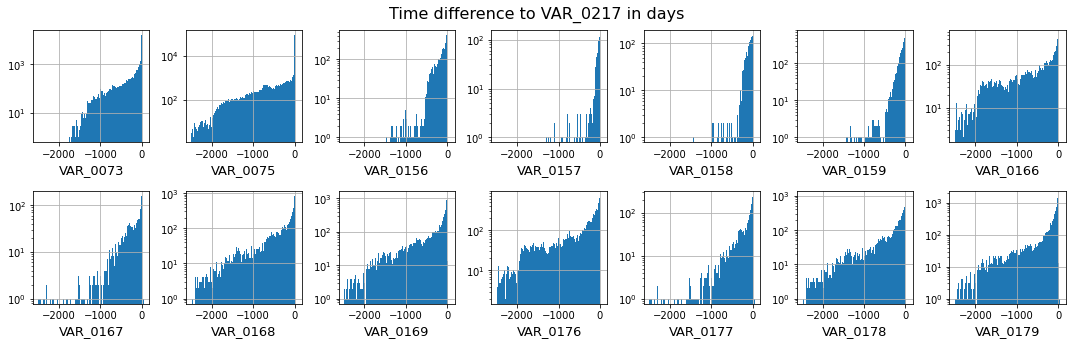

In [23]:
cols_t = sorted(set(dft_diff.columns) - set(['VAR_0204','VAR_0217']))

fig, ax = plt.subplots(2,7,figsize=(15,5))

ax = ax.ravel()

fig.suptitle('Time difference to VAR_0217 in days',fontsize=16)

for i, col in enumerate(cols_t):
    
    tunit = np.timedelta64(1,'D')
    
    ax[i].hist((dft[col]-dft['VAR_0217'])/tunit,range=(-2500,50),bins=255)

    ax[i].grid()
    ax[i].set_yscale('log')
    ax[i].set_xlabel(col,fontsize=13)

fig.tight_layout(rect=[0, 0.03, 1, 0.95]);

Interesting, that all the distributions are steeply falling from 0 to earlier days. This means that VAR_217 might describe an upper limit of the dates recorded in other columns.

There's also column VAR_075 that is fully filled with data, just like columns VAR_205 and VAR_217. Let's plot the time difference relative this column too:

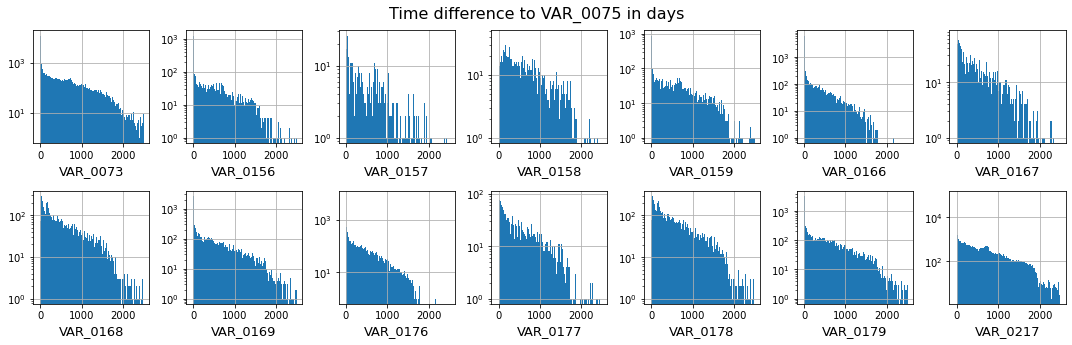

In [24]:
cols_t = sorted(set(dft_diff.columns) - set(['VAR_0204','VAR_0075']))

fig, ax = plt.subplots(2,7,figsize=(15,5))

ax = ax.ravel()

fig.suptitle('Time difference to VAR_0075 in days',fontsize=16)

for i, col in enumerate(cols_t):
    
    tunit = np.timedelta64(1,'D')
    
    ax[i].hist((dft[col]-dft['VAR_0075'])/tunit,range=(-50,2500),bins=255)

    ax[i].grid()
    ax[i].set_yscale('log')
    ax[i].set_xlabel(col,fontsize=13)

fig.tight_layout(rect=[0, 0.03, 1, 0.95]);

The distributions are steeply falling from 0 again, this time to higher values (later dates). Combined with the previous observation, this implies that VAR_075 and VAR_217 cover the range of dates populated by other columns. In most cases the difference between them is zero (the same date), which would explain why other colums have so many NaNs. 

To proceed to the next step we will skip column VAR_204, convert column VAR_217 to an integer describing the number of days relative to the lowest date in that column. We will also skip column VAR_075. Finally, we will count the numbers of other non-zero datetime columns and interpret it as number of treatments a patient surveyed in columns VAR_217 underwent. After this step, 16 datetime columns will get reduced to only 2 integer columns.

### 4. String-type features<a id='4'></a>

__MORE TO COME__

Inspect 2 columns with US state codes, and two columns with profession names. 

Conversion of city name to city population in the next chapter when doing feature engineering.

### 5. Summary<a id='5'></a>